Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [23]:
from os.path import basename, exists

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [24]:
import numpy as np

import thinkstats2
import thinkplot

In [25]:
import brfss


df = brfss.ReadBrfss(nrows=None)

In [26]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

**Exercise:7.0**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

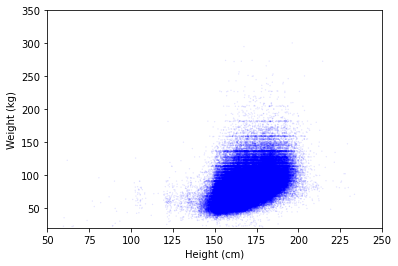

In [52]:
# Solution
heights = Jitter(df.htm3,1.3)
weights = Jitter(df.wtkg2,0.5)

thinkplot.Scatter(heights, weights, alpha=0.1, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[50, 250, 20, 350],
                 legend=False)

**Exercise:7.1** Yet another option is to divide the dataset into groups and then plot the CDF for each group. As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

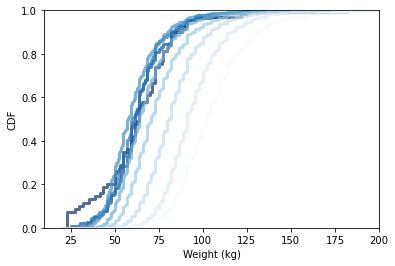

In [97]:
# Solution
clean_data = df.dropna(subset=['htm3', 'wtkg2'])
bins = np.arange(120,200,10)
indices = np.digitize(clean_data.htm3, bins)
groups = clean_data.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[10, 200, 0, 1],
                 legend=False)

 **Exercises :7.2**

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [114]:
from scipy.stats import spearmanr
import pandas as pd

In [143]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [116]:
def Spearmancorrcalc(x,y):
    return spearmanr(x, y)


In [146]:
ages = live.agepreg
weight = live.totalwgt_lb

In [147]:
corr,p = Spearmancorrcalc(ages,weight)

**Speraman correlation**

In [148]:
print(corr)

0.09461004109658226


In [149]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [150]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

**Pearson Correlation**

In [151]:
Corr(ages,weight)

0.0688339703541091

In [153]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'weight(lbs)')

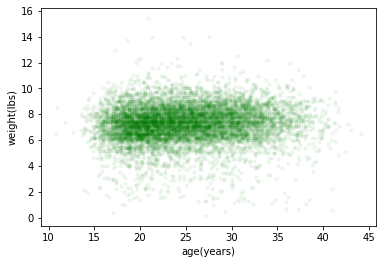

In [164]:
plt.scatter(ages,weight,color='Green',alpha=0.05,s=10)
plt.xlabel('age(years)')
plt.ylabel('weight(lbs)')

Based on the values between the perarson and speramans , the relation looks non-linear

Also the scatter plot shows that the week relation between the two variables.

**Exercise:8.1** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



In [173]:
import random
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

standard error 0.8821364901570485
confidence interval (1.322675844419121, 3.8603925822536773)


0.8821364901570485

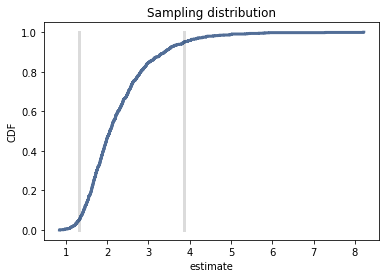

In [182]:
# Solution

def SimulateSample(lam=2, n=10, iters=1000):
    """Sampling distribution of L as an estimator of exponential parameter.

    lam: parameter of an exponential distribution
    n: sample size
    iters: number of iterations
    """
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SimulateSample()

**Exercise:8.2** In games like hockey and soccer, the time between goals is roughly exponential. So you could estimate a team’s goal-scoring rate by observing the number of goals they score in a game. This estimation process is a little different from sampling the time between goals, so let’s see how it works.

Write a function that takes a goal-scoring rate, lam, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.

Write another function that simulates many games, stores the estimates of lam, then computes their mean error and RMSE.

Is this way of making an estimate biased?

In [183]:
def SimulateGame(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1

    # estimated goal-scoring rate is the actual number of goals scored
    L = goals
    return L

In [184]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

Experiment 4
rmse L 1.4121989944763451
mean error L 0.000212


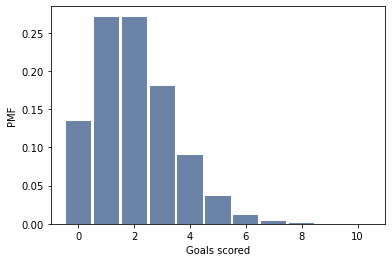

In [185]:
# Solution

# The following function simulates many games, then uses the
# number of goals scored as an estimate of the true long-term
# goal-scoring rate.

def Estimate6(lam=2, m=1000000):

    estimates = []
    for i in range(m):
        L = SimulateGame(lam)
        estimates.append(L)

    print('Experiment 4')
    print('rmse L', RMSE(estimates, lam))
    print('mean error L', MeanError(estimates, lam))
    
    pmf = thinkstats2.Pmf(estimates)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel='Goals scored', ylabel='PMF')
    
Estimate6()

 The mean error is small and decreases with m, so this estimator
appears to be unbiased

**Exercise:8.3** In this chapter we used  𝑥¯  and median to estimate µ, and found that  𝑥¯  yields lower MSE. Also, we used  𝑆2  and  𝑆2𝑛−1  to estimate σ, and found that  𝑆2  is biased and  𝑆2𝑛−1  unbiased. Run similar experiments to see if  𝑥¯  and median are biased estimates of µ. Also check whether  𝑆2  or  𝑆2𝑛−1  yields a lower MSE.

In [186]:
# Solution

def Estimate4(n=7, iters=100000):
    """Mean error for xbar and median as estimators of population mean.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('mean error xbar', MeanError(means, mu))
    print('mean error median', MeanError(medians, mu))
    
Estimate4()

Experiment 1
mean error xbar -0.0016881254678869553
mean error median -0.0009744071372845684


In [187]:
# Solution

def Estimate5(n=7, iters=100000):
    """RMSE for biased and unbiased estimators of population variance.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('Experiment 2')
    print('RMSE biased', RMSE(estimates1, sigma**2))
    print('RMSE unbiased', RMSE(estimates2, sigma**2))

Estimate5()

Experiment 2
RMSE biased 0.5148414035841536
RMSE unbiased 0.5770772461850262
